In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

In [2]:
import sys
sys.path.append('library');

# Variable globales

In [3]:
## Seed for the random variables
seed_number=0;

## Dataset 
dataset_base_dir     = '/mnt/boveda/DATASETs/PATIENT-IMAGES/patient_people/train';
dataset_labels_file  = 'training_labels.csv';

dataset_base_test_dir= '/mnt/boveda/DATASETs/PATIENT-IMAGES/patient_people/test';


## Training hyperparameters
EPOCAS=50;
BATCH_SIZE=32;

## Model of network
model_type = 'efficientnet_b3'
#model_type = 'mobilenet_v3';
#model_type = 'inception_v3';
#model_type = 'inception_resnet_v2';
#model_type = 'resnet_v2_50';

## Output
output_base_dir = '/mnt/boveda/DOCTORADO2/cnn_patient_people/train';



# Set seed of random variables


In [4]:
np.random.seed(seed_number)
tf.keras.utils.set_random_seed(seed_number);

# Loading data of dataset

In [5]:
# Load filenames and labels
train_data = pd.read_csv(os.path.join(dataset_base_dir,dataset_labels_file));
print(train_data)
# Setting labels
Y = train_data[['label']];
L=np.shape(Y)[0];


                    filename    label
0       people/filename1.png   people
1      patient/filename1.png  patient
2       people/filename2.png   people
3      patient/filename2.png  patient
4       people/filename3.png   people
..                       ...      ...
626  patient/filename456.png  patient
627  patient/filename457.png  patient
628  patient/filename458.png  patient
629  patient/filename459.png  patient
630  patient/filename460.png  patient

[631 rows x 2 columns]


# Setting the cross-validation split


In [6]:
from sklearn.model_selection import train_test_split
    



training_data, validation_data = train_test_split(train_data, test_size=0.2,shuffle=True, stratify=Y)



# Data augmentation configuration

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

idg    = ImageDataGenerator(rescale=1./255,
                            rotation_range = 10,
                            width_shift_range= 0.07,
                            height_shift_range= 0.07,
                            horizontal_flip=True,
                            shear_range=1.25,
                            zoom_range = [0.75, 1.25] 
                            )

idg_val= ImageDataGenerator(rescale=1./255 )

idg_test= ImageDataGenerator(rescale=1./255 )


# Creating output directory

In [8]:
#output_dir = os.path.join(output_base_dir,'holdout');
output_dir = os.path.join(output_base_dir,'holdout_'+model_type);
try: 
    os.mkdir(output_base_dir) 
except: 
    pass

try: 
    os.mkdir(output_dir) 
except: 
    pass


# Create new model

In [9]:
import lib_model as mpp

model, target_size = mpp.create_model('',model_type=model_type);
model.summary()

mpp.save_model_parameters(model, os.path.join(output_dir,'parameters_stats.m'));


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1536)              10783528  
                                                                 
 dense (Dense)               (None, 2)                 3074      
                                                                 
Total params: 10,786,602
Trainable params: 3,074
Non-trainable params: 10,783,528
_________________________________________________________________


# Defining directories

In [10]:

train_data_generator = idg.flow_from_dataframe(training_data, 
                                               directory = dataset_base_dir,
                                               target_size=target_size,
                                               x_col = "filename", 
                                               y_col = "label",
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical",
                                               shuffle = True);

valid_data_generator  = idg_val.flow_from_dataframe(validation_data, 
                                                    directory = dataset_base_dir,
                                                    target_size=target_size,
                                                    x_col = "filename", 
                                                    y_col = "label",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    shuffle = True);

test_data_generator  = idg_test.flow_from_directory(dataset_base_test_dir, 
                                                    target_size=target_size,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True
                                                    );

Found 504 validated image filenames belonging to 2 classes.
Found 127 validated image filenames belonging to 2 classes.
Found 273 images belonging to 2 classes.


# Train and validation


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 0.5709 - accuracy: 0.6984
Epoch 1: val_accuracy improved from -inf to 0.85827, saving model to /mnt/boveda/DOCTORADO2/cnn_patient_people/train/holdout_efficientnet_b3/model.h5
16/16 [==============================] - 93s 5s/step - loss: 0.5709 - accuracy: 0.6984 - val_loss: 0.3638 - val_accuracy: 0.8583
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 0.3177 - accuracy: 0.8929
Epoch 2: val_accuracy improved from 0.85827 to 0.88976, saving model to /mnt/boveda/DOCTORADO2/cnn_patient_people/train/holdout_efficientnet_b3/model.h5
16/16 [==============================] - 77s 5s/step - loss: 0.3177 - accuracy: 0.8929 - val_loss: 0.2642 - val_accuracy: 0.8898
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 0.2621 - accuracy: 0.9008
Epoch 3: val_accuracy improved from 0.88976 to 0.89764, saving model to /mnt/boveda/DOCTORADO2/cnn_patient_people/train/holdout_efficientnet_b3/model.h5
16/1

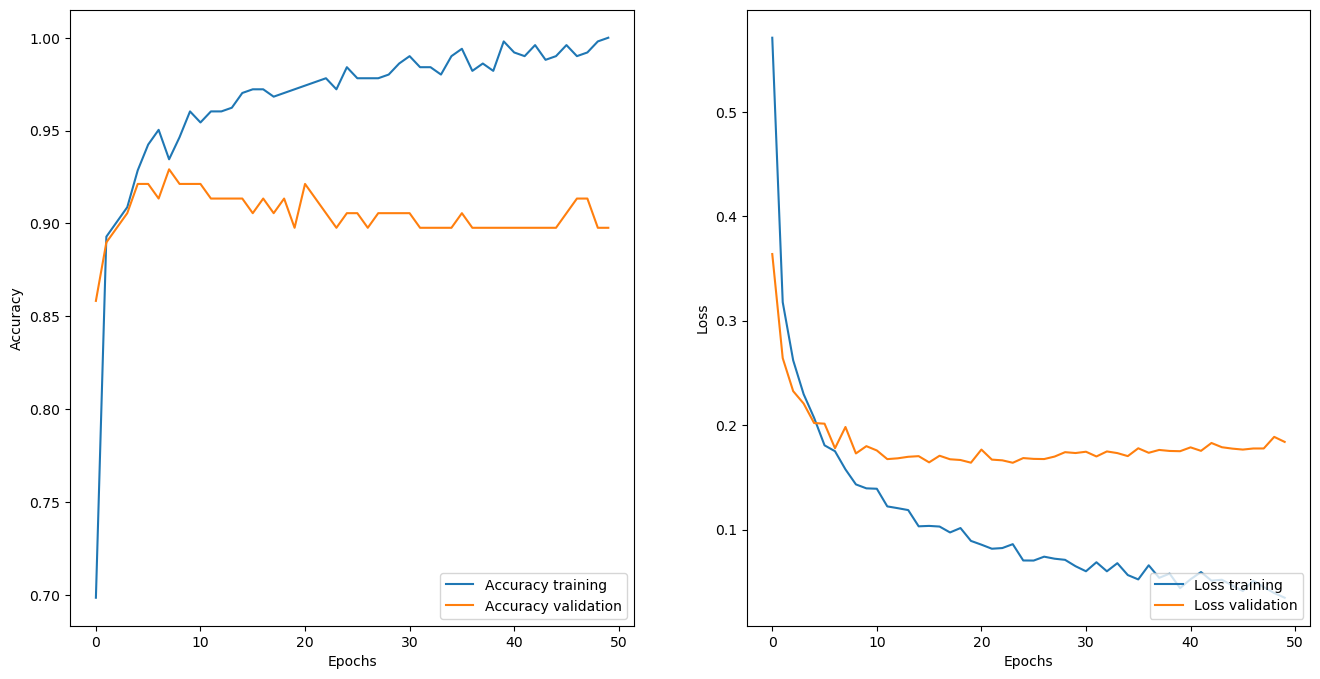

max_val_acc 0.9291338324546814


In [11]:
import matplotlib.pyplot as plt


STEPS_BY_EPOCHS=len(train_data_generator);

# COMPILE NEW MODEL
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# CREATE CALLBACKS
best_model_file=os.path.join(output_dir,'model.h5');
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_file, 
                                                save_weights_only=True,
                                                monitor='val_accuracy', 
                                                save_best_only=True, 
                                                verbose=1);



# There can be other callbacks, but just showing one because it involves the model name
# This saves the best model
# FIT THE MODEL
history = model.fit(train_data_generator,
                    steps_per_epoch=STEPS_BY_EPOCHS,
                    epochs=EPOCAS,
                    validation_data=valid_data_generator,
                    callbacks=[checkpoint],
                    verbose=1
                   );


mpp.save_model_history(history,os.path.join(output_dir,"historical.csv"));


# Evaluate best model

In [12]:
# LOAD BEST MODEL to evaluate the performance of the model
model.load_weights(best_model_file);

results = model.evaluate(test_data_generator)
results = dict(zip(model.metrics_names,results))
print(results,"\n\n");

with open(os.path.join(output_dir,"results_testing.txt"), 'w') as f: 
    for key, value in results.items(): 
        f.write('%s=%s;\n' % (key, value));

tf.keras.backend.clear_session()


9/9 [==============================] - 33s 4s/step - loss: 0.1031 - accuracy: 0.9744
{'loss': 0.10306092351675034, 'accuracy': 0.9743589758872986} 




In [13]:

POSTNAME=str(int(results['accuracy']*100000));

tmp_name='modelo_'+model_type+'_acc'+POSTNAME+'.h5';

os.rename(best_model_file,os.path.join(output_dir,tmp_name));